[View in Colaboratory](https://colab.research.google.com/github/kinishikawa/learning/blob/master/test/Untitled0.ipynb)

**Tensorflowを用いて, MNISTを畳み込みニューラルネットワーク(CNN)で学習せよ¶**

In [0]:
def homework(train_X, train_y, test_X):
    # WRITE ME!
    rng = np.random.RandomState(1234)
    random_state = 42
    
    train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.1, random_state=random_state)
    
    # Convolution Layer
    class Conv:
        def __init__(self, filter_shape, function=lambda x: x, strides=(1,1,1,1), padding='VALID'):
            # Xavier
            fan_in = np.prod(filter_shape[:3])
            fan_out = np.prod(filter_shape[:2]) * filter_shape[3]
            self.W = tf.Variable(rng.uniform(
                            low=-np.sqrt(6/(fan_in + fan_out)),
                            high=np.sqrt(6/(fan_in + fan_out)),
                            size=filter_shape
                        ).astype('float32'), name='W')
            self.b = tf.Variable(np.zeros((filter_shape[3]), dtype='float32'), name='b')
            self.function = function
            self.strides = strides
            self.padding = padding
            self.params = [self.W, self.b]

        def f_prop(self, x):
            conv_out = tf.nn.conv2d(x, self.W, strides=self.strides, padding=self.padding)
            return self.function(tf.nn.bias_add(conv_out, self.b))
    
    # Pooling Layer
    class Pooling:
        def __init__(self, ksize=(1,2,2,1), strides=(1,2,2,1), padding='VALID'):
            self.ksize = ksize
            self.strides = strides
            self.padding = padding
            self.params = []

        def f_prop(self, x):
            return tf.nn.max_pool(x, ksize=self.ksize, strides=self.strides, padding=self.padding)
        
    # Flatten Layer
    class Flatten:
        def __init__(self):
            self.params = []

        def f_prop(self, x):
            return tf.reshape(x, (-1, np.prod(x.get_shape().as_list()[1:])))
        
    # Dense Layer
    class Dense:
        def __init__(self, in_dim, out_dim, function=lambda x: x):
            # Xavier
            self.W = tf.Variable(rng.uniform(
                            low=-np.sqrt(6/(in_dim + out_dim)),
                            high=np.sqrt(6/(in_dim + out_dim)),
                            size=(in_dim, out_dim)
                        ).astype('float32'), name='W')
            self.b = tf.Variable(np.zeros([out_dim]).astype('float32'))
            self.function = function
            self.params = [self.W, self.b]

        def f_prop(self, x):
            return self.function(tf.matmul(x, self.W) + self.b)
        
    # SGD
    def sgd(cost, params, eps=np.float32(0.1)):
        g_params = tf.gradients(cost, params)
        updates = []
        for param, g_param in zip(params, g_params):
            if g_param != None:
                updates.append(param.assign_add(-eps*g_param))
        return updates
    
    # Layer Network
    layers = [
        Conv((5, 5, 1, 20), tf.nn.relu),  # 28x28x 1 -> 24x24x20
        Pooling((1, 2, 2, 1)),            # 24x24x20 -> 12x12x20
        Conv((5, 5, 20, 50), tf.nn.relu), # 12x12x20 ->  8x 8x50
        Pooling((1, 2, 2, 1)),            #  8x 8x50 ->  4x 4x50
        Flatten(),
        Dense(4*4*50, 10, tf.nn.softmax)
    ]

    x = tf.placeholder(tf.float32, [None, 28, 28, 1])
    t = tf.placeholder(tf.float32, [None, 10])

    def f_props(layers, x):
        params = []
        for layer in layers:
            x = layer.f_prop(x)
            params += layer.params
        return x, params

    y, params = f_props(layers, x)

    cost = -tf.reduce_mean(tf.reduce_sum(t * tf.log(y), axis=1))
    updates = sgd(cost, params)

    train = tf.group(*updates)
    valid = tf.argmax(y, 1)
    
    n_epochs = 10
    batch_size = 100
    n_batches = train_X.shape[0]//batch_size

    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(n_epochs):
            train_X, train_y = shuffle(train_X, train_y, random_state=random_state)
            for i in range(n_batches):
                start = i * batch_size
                end = start + batch_size
                sess.run(train, feed_dict={x: train_X[start:end], t: train_y[start:end]})
            pred_y, valid_cost = sess.run([valid, cost], feed_dict={x: valid_X, t: valid_y})
            print('EPOCH:: %i, Validation cost: %.3f, Validation F1: %.3f' % (epoch + 1, valid_cost, f1_score(np.argmax(valid_y, 1).astype('int32'), pred_y, average='macro')))
            
        pred_y = sess.run(y, feed_dict={x: test_X})
        pred_y =  np.argmax(pred_y, 1).astype('int32')

#     save(layers)
        
    return pred_y


In [0]:
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tensorflow.examples.tutorials.mnist import input_data

import numpy as np
import tensorflow as tf

# del [
#     tf.app,
#     tf.compat,
#     tf.contrib,
#     tf.errors,
#     tf.gfile,
#     tf.graph_util,
#     tf.image,
#     tf.layers,
#     tf.logging,
#     tf.losses,
#     tf.metrics,
#     tf.python_io,
#     tf.resource_loader,
#     tf.saved_model,
#     tf.sdca,
#     tf.sets,
#     tf.summary,
#     tf.sysconfig,
#     tf.test
# ]

def load_mnist():
    mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)
    mnist_X = np.r_[mnist.train.images, mnist.test.images]
    mnist_y = np.r_[mnist.train.labels, mnist.test.labels]
    return train_test_split(mnist_X, mnist_y, test_size=0.2, random_state=42)

def validate_homework():
    train_X, test_X, train_y, test_y = load_mnist()
    train_X = train_X.reshape((train_X.shape[0], 28, 28, 1))
    test_X = test_X.reshape((test_X.shape[0], 28, 28, 1))

    # validate for small dataset
    train_X_mini = train_X[:100]
    train_y_mini = train_y[:100]
    test_X_mini = test_X[:100]
    test_y_mini = test_y[:100]

    pred_y = homework(train_X_mini, train_y_mini, test_X_mini)
    print(f1_score(np.argmax(test_y_mini, 1), pred_y, average='macro'))

#     show(test_X_mini,test_y_mini,pred_y)
    
def score_homework():
    train_X, test_X, train_y, test_y = load_mnist()
    train_X = train_X.reshape((train_X.shape[0], 28, 28, 1))
    test_X = test_X.reshape((test_X.shape[0], 28, 28, 1))
    
    pred_y = homework(train_X, train_y, test_X)
    print(f1_score(np.argmax(test_y, 1), pred_y, average='macro'))
    
    show(test_X,test_y,pred_y)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
EPOCH:: 1, Validation cost: 0.112, Validation F1: 0.967
EPOCH:: 2, Validation cost: 0.076, Validation F1: 0.976
EPOCH:: 3, Validation cost: 0.061, Validation F1: 0.982
EPOCH:: 4, Validation cost: 0.064, Validation F1: 0.982
EPOCH:: 5, Validation cost: 0.074, Validation F1: 0.978
EPOCH:: 6, Validation cost: 0.046, Validation F1: 0.987
EPOCH:: 7, Validation cost: 0.048, Validation F1: 0.985
EPOCH:: 8, Validation cost: 0.048, Validation F1: 0.984
EPOCH:: 9, Validation cost: 0.043, Validation F1: 0.987
EPOCH:: 10, Validation cost: 0.042, Validation F1: 0.987
0.9850635944790727
正解 [6 6 9 7 0 0 3 1 3]
正解 [1 3 0 2 3 2 4 9 1]
正解 [2 6 8 6 9 2 6 6 7]
正解 [6 7 6 6 1 8 5 4 3]
正解 [9 0 0 0 0 8 1 6 7]
正解 [6 7 9 9 5 5 2 5 1]
正解 [0 1 4 1 2 0 2 1 1]
正解 [9 8 3 1 8 6 0 5 7]
正解 [7 0 6 5 7 3 5 1 0]
予測 [6 6 9 7 0 0 3 1

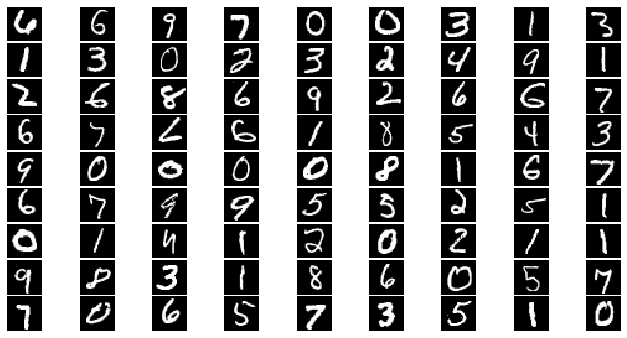

In [76]:
# validate_homework()
score_homework()

In [0]:
import matplotlib.pyplot as plt

def show(test_X,test_y,pred_y):
    test_y = np.argmax(test_y, 1).astype('int32')

    
    
    for j in range(9):
      sta = j * 9
      end = (j+1) *9

      print("正解", test_y[sta:end])

      
    for j in range(9):
      sta = j * 9
      end = (j+1) *9

      print("予測", pred_y[sta:end])
    
    

    fig = plt.figure(figsize=(9, 9))
    fig.subplots_adjust(left=0, right=1, bottom=0,
                    top=0.5, hspace=0.05, wspace=0.05)

    for i in range(81):
        ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
        ax.imshow(test_X[i].reshape((28, 28)), cmap='gray')
  
     

Pickleのテスト

In [0]:
import pickle

def save(layers):
  
    with open('layers.pickle', 'wb') as f:
        pickle.dump(layers, f)
        
    print('save layers.pickle')


In [0]:
def load():
  
    with open('layers.pickle', 'rb') as f:
        layers = pickle.load(f)

    return layers


In [0]:
train_X, test_X, train_y, test_y = load_mnist()
train_X = train_X.reshape((train_X.shape[0], 28, 28, 1))
test_X = test_X.reshape((test_X.shape[0], 28, 28, 1))

x = tf.placeholder(tf.float32, [None, 28, 28, 1])
# t = tf.placeholder(tf.float32, [None, 10])

layers = load()

def f_props(layers, x):
    params = []
    for layer in layers:
        x = layer.f_prop(x)
    return x

y = f_props(layers, x)

valid = tf.argmax(y, 1)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)

    pred_y = sess.run(y, feed_dict={x: test_X})
    pred_y = np.argmax(pred_y, 1).astype('int32')

    
show(test_X,test_y,pred_y)
  